In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import os
import shutil

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

### Load and Join Data into Dataframes

In [2]:
# starting districting plan order of districts
demo_ints = [14, 13, 10, 11, 18, 4, 1, 9, 8, 17, 12, 7, 5, 15, 6, 16, 2, 3] # remedial map
demo_cols = ['d' + str(val) for val in demo_ints]

# observations
steps = 1000

df_polsby = pd.DataFrame(pd.read_csv('Outputs/master_polsby.csv', names=['pols_value']))
df_reock = pd.DataFrame(pd.read_csv('Outputs/master_reock.csv', names=['reock_value']))
df_schwartz = pd.DataFrame(pd.read_csv('Outputs/master_schwartz.csv', names=['schwartz_value']))
df_compacts = df_polsby.join([df_reock, df_schwartz])

df_bpop = pd.DataFrame(pd.read_csv('Outputs/black_pop.csv', names=['bpop']))
df_wpop = pd.DataFrame(pd.read_csv('Outputs/white_pop.csv', names=['wpop']))
df_area = pd.DataFrame(pd.read_csv('Outputs/areas.csv', names=['area']))
df_perim = pd.DataFrame(pd.read_csv('Outputs/perimeters.csv', names=['perimeter']))

df_compacts = df_compacts.join([df_bpop, df_wpop, df_area, df_perim])

### Helper Functions

In [3]:
def df_importer(file_list, cols):
    """
    Imports data and calculates the mean, max, and min for each column in cols. Returns a dataframe with those values as columns. 
    Used to get statewide partisan metrics in usable format.

    Paramters: 
        file_list: list - list of data file names as strings to import. Must be CSVs
        cols: list - list of column names as strings to calculate the mean, max, and min of

    return: 
        ret_df: pd.Dataframe - dataframe with mean, max, and min of statewide partisan metrics 
    """
    # intialize return dataframe
    ret_df = pd.DataFrame()

    # loop through data files
    for data in file_list:
        
        # load data
        temp_df = pd.read_csv('Outputs/'+data, names=cols)

        # get name of metric
        substring = data.split('.')[0]

        # calculate mean, max, min
        ret_df[substring+'_avg'] = temp_df.mean(axis=1)
        ret_df[substring+'_max'] = temp_df.max(axis=1)
        ret_df[substring+'_min'] = temp_df.min(axis=1)

    return ret_df

In [4]:
def threshold_labeler(data, col, num_std=1, two_sided=False, min_val=-1, max_val=1):
    """
    Creates binary True/False label column in dataframe for observations based on provided parameters.

    Paramters: 
        data: pd.Dataframe - dataframe to be used
        col: str - metric column to be used to set thresholds and generate labels
        num_std: int or float - number of standard deviations away from mean to set threshold. Default=1
        two_sided: Boolean - whether metric is two sided with scale from [-1, 1] or not (scale [0, 1]). Default=False
        min_val: int or float - minimum value on metric scale. Default=-1
        max_val: int or float - maximum value on metric scale. Default=1

    return: 
        None - adds column with suffix '_label' to data
    """
    # set thresholds
    low_bound = data[col].mean() - (data[col].std() * num_std)
    up_bound = data[col].mean() + (data[col].std() * num_std)

    # generate observation label column
    if two_sided:
        data[f'{col}_label'] = pd.cut(data[col], [min_val, low_bound, up_bound, max_val], labels=[True, False, True], ordered=False)
    
    else:
        data[f'{col}_label'] = np.where(data[col] < low_bound, True, False)

### Visualize, Set Thresholds, Label Data

In [5]:
# create timestep column to group districts with their respective statewide plan
tlist = len(demo_cols)*[str(val) for val in np.arange(start=1, stop=steps+1)]
tlist = [int(x) for x in tlist]
tlist.sort()
df_compacts['timestep'] = tlist

In [6]:
df_compacts

,pols_value,reock_value,schwartz_value,bpop,wpop,area,perimeter,timestep
0,0.238830,0.339847,0.488702,36019,677931,1.010285,7.290923,1
1,0.355307,0.529951,0.596076,13015,688064,2.686992,9.748471,1
2,0.253854,0.405090,0.503839,15008,683961,2.787175,11.746140,1
3,0.234638,0.305855,0.484394,17619,696067,1.602385,9.263802,1
4,0.234423,0.590401,0.484173,15704,690406,0.919772,7.021737,1
...,...,...,...,...,...,...,...,...
17995,0.186155,0.289464,0.431457,16882,673778,2.327884,12.535688,1000
17996,0.130914,0.351513,0.361820,332204,380033,0.013510,1.138791,1000
17997,0.203841,0.441336,0.451487,23545,680305,0.397457,4.949993,1000
17998,0.173445,0.267047,0.416467,57739,659706,0.746859,7.356028,1000


In [7]:
# groupby timestep so each observation is a statewide districting plan
# calculate max, min, and difference for columns in d_cols

d_cols = ['wpop', 'bpop', 'area', 'perimeter']

# max value in statewide districting plan
max_df = df_compacts.groupby(by='timestep').max().reset_index()
max_df = max_df[d_cols]
max_df.columns = ['max_'+c for c in max_df.columns]

# min value in statewide districting plan
min_df = df_compacts.groupby(by='timestep').min().reset_index()
min_df = min_df[d_cols]

# join and calculate difference
demo_df = max_df.join([min_df])
demo_df['wpop_diff'] = demo_df['max_wpop'] - demo_df['wpop']
demo_df['bpop_diff'] = demo_df['max_bpop'] - demo_df['bpop']
demo_df['area_diff'] = demo_df['max_area'] - demo_df['area']
demo_df['perim_diff'] = demo_df['max_perimeter'] - demo_df['perimeter']

# drop irrelevant columns
demo_df.drop(columns=['max_wpop', 'max_bpop', 'max_area', 'max_perimeter', 'wpop', 'bpop', 'area', 'perimeter'], inplace=True)

demo_df

,wpop_diff,bpop_diff,area_diff,perim_diff
0,324582,314017,2.769113,11.046070
1,281442,268896,2.749611,11.476393
2,283686,278822,2.748678,12.676845
3,337560,334332,2.753484,12.647452
4,316694,314007,2.753855,11.264670
...,...,...,...,...
995,283655,285993,3.072140,11.514732
996,308874,298478,3.068363,11.371555
997,394308,399013,2.472670,13.089985
998,293792,291236,2.476877,13.361365


In [8]:
# import and clean metric data

# metric data files
metrics_files = [
    'egs.csv', 'hmss.csv',
    'mms.csv', 'partisan_bias.csv',
    'partisan_gini.csv'
]

# metric columns
election_names = [
    "ATG12",
    "GOV14",
    "GOV10",
    "PRES12",
    "SEN10",
    "ATG16",
    "PRES16",
    "SEN16",
    "SEN12"
]

metric_df = df_importer(metrics_files, election_names)

In [9]:
metric_df

,egs_avg,egs_max,egs_min,hmss_avg,hmss_max,hmss_min,mms_avg,mms_max,mms_min,partisan_bias_avg,partisan_bias_max,partisan_bias_min,partisan_gini_avg,partisan_gini_max,partisan_gini_min
0,-0.058817,0.040833,-0.191956,8.222222,12,5,-0.020685,-0.005474,-0.037666,-0.092593,0.000000,-0.166667,0.061916,0.068080,0.055170
1,-0.043926,0.049156,-0.189639,8.444444,12,4,-0.014849,0.004673,-0.027027,-0.074074,0.055556,-0.166667,0.057309,0.064592,0.051912
2,-0.064101,0.050133,-0.201673,8.111111,12,4,-0.015108,-0.000273,-0.033917,-0.111111,0.000000,-0.222222,0.073879,0.085840,0.068190
3,-0.045670,0.048535,-0.244378,8.444444,12,3,-0.012823,-0.000108,-0.027573,-0.092593,0.000000,-0.222222,0.077033,0.088474,0.071877
4,-0.039425,0.083206,-0.244378,8.555556,12,3,-0.012247,-0.000335,-0.025626,-0.092593,0.000000,-0.222222,0.077285,0.088715,0.071861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.054205,0.037601,-0.247334,8.222222,12,3,-0.023570,-0.014153,-0.034011,-0.098765,0.000000,-0.166667,0.074378,0.089728,0.066427
996,-0.108233,0.035803,-0.192664,7.444444,12,4,-0.039180,-0.031596,-0.050019,-0.166667,-0.111111,-0.222222,0.076841,0.087289,0.068867
997,-0.114754,0.029939,-0.209132,7.333333,12,4,-0.047890,-0.039747,-0.058298,-0.148148,-0.111111,-0.222222,0.087218,0.096700,0.080973
998,-0.100435,0.028735,-0.144008,7.555556,12,5,-0.047598,-0.039579,-0.058773,-0.141975,-0.111111,-0.166667,0.076042,0.083795,0.067180


<AxesSubplot:title={'center':'Statewide EGS Metric'}, ylabel='Frequency'>

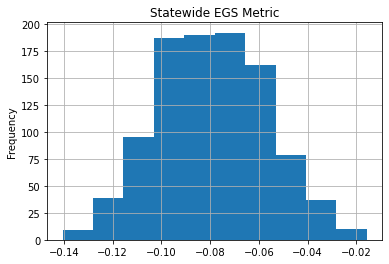

In [10]:
# visualize EGS metric for all observations
metric_df['egs_avg'].plot(kind='hist', title='Statewide EGS Metric', grid=True)

<AxesSubplot:title={'center':'Statewide EGS Metric'}, ylabel='Frequency'>

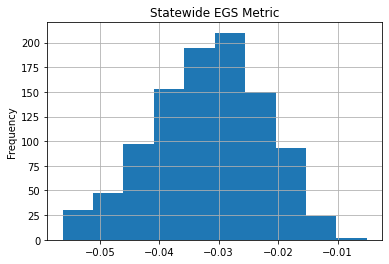

In [14]:
metric_df['mms_avg'].plot(kind='hist', title='Statewide EGS Metric', grid=True)

In [19]:
metric_df['egs_avg'].describe()

count    1000.000000
mean       -0.079056
std         0.022240
min        -0.140571
25%        -0.095101
50%        -0.079462
75%        -0.063100
max        -0.015642
Name: egs_avg, dtype: float64

In [22]:
# set thresholds and label data for each statewide partisan metric
    
threshold_labeler(metric_df, 'hmss_avg', num_std=0.5)
threshold_labeler(metric_df, 'partisan_bias_avg', num_std=0.5)
threshold_labeler(metric_df, 'egs_avg', num_std=0.5)
threshold_labeler(metric_df, 'mms_avg', num_std=0.5)

In [23]:
# value counts for each metric label
print('hmss:',metric_df['hmss_avg_label'].value_counts())
print('part_bias:',metric_df['partisan_bias_avg_label'].value_counts())
print('egs:',metric_df['egs_avg_label'].value_counts())
print('mms:',metric_df['mms_avg_label'].value_counts())

hmss: False    621
True     379
Name: hmss_avg_label, dtype: int64
part_bias: False    706
True     294
Name: partisan_bias_avg_label, dtype: int64
egs: False    666
True     334
Name: egs_avg_label, dtype: int64
mms: False    692
True     308
Name: mms_avg_label, dtype: int64


In [26]:
# generate fin_label column - composite of partisan metrics - must have 2 or more True values among the 4 metrics to have True
# value for fin_label
metric_df['label_sum'] = metric_df[['hmss_avg_label','partisan_bias_avg_label','egs_avg_label','mms_avg_label']].sum(axis=1)
metric_df['fin_label'] = np.where(metric_df['label_sum'] >= 2, True, False)
metric_df['fin_label'].value_counts()

False    620
True     380
Name: fin_label, dtype: int64

In [27]:
# add fin_label column to demographic data
demo_df['label'] = metric_df['fin_label']
demo_df

,wpop_diff,bpop_diff,area_diff,perim_diff,label
0,324582,314017,2.769113,11.046070,False
1,281442,268896,2.749611,11.476393,False
2,283686,278822,2.748678,12.676845,False
3,337560,334332,2.753484,12.647452,False
4,316694,314007,2.753855,11.264670,False
...,...,...,...,...,...
995,283655,285993,3.072140,11.514732,False
996,308874,298478,3.068363,11.371555,True
997,394308,399013,2.472670,13.089985,True
998,293792,291236,2.476877,13.361365,True


In [28]:
# match each observation with its image file name
start = 10
stop = 10001
step = 10

demo_df['image_file'] = ['state_plot' + str(x) + '.png' for x in np.arange(start,stop,step)]

demo_df

,wpop_diff,bpop_diff,area_diff,perim_diff,label,image_file
0,324582,314017,2.769113,11.046070,False,state_plot10.png
1,281442,268896,2.749611,11.476393,False,state_plot20.png
2,283686,278822,2.748678,12.676845,False,state_plot30.png
3,337560,334332,2.753484,12.647452,False,state_plot40.png
4,316694,314007,2.753855,11.264670,False,state_plot50.png
...,...,...,...,...,...,...
995,283655,285993,3.072140,11.514732,False,state_plot9960.png
996,308874,298478,3.068363,11.371555,True,state_plot9970.png
997,394308,399013,2.472670,13.089985,True,state_plot9980.png
998,293792,291236,2.476877,13.361365,True,state_plot9990.png


### Train-Test-Split, Save Data

In [29]:
demo_df.to_csv('Outputs/cleaned_statewide_data_8.29.csv')

In [30]:
train_master, test_master = train_test_split(demo_df, test_size=0.2)
train_master, val_master = train_test_split(train_master, test_size=0.1)

In [31]:
train_master.to_csv('Outputs/statewide_train_data_.csv')
test_master.to_csv('Outputs/statewide_test_data_.csv')
val_master.to_csv('Outputs/statewide_val_data_.csv')

### Oversample True class
    - Building and saving data with an oversampled True class

In [28]:
# oversampling with a Random Over Sampler

X_hetero = demo_df[['wpop_diff', 'bpop_diff', 'area_diff', 'image_file']]
y_hetero = demo_df['label']

ros = RandomOverSampler(random_state=0)
x_resample, y_resample = ros.fit_resample(X_hetero, y_hetero)

In [29]:
y_resample.value_counts()

True     196
False    196
Name: label, dtype: int64

In [30]:
over_df = x_resample.join([y_resample])
over_df

,wpop_diff,bpop_diff,area_diff,image_file,label
0,406004,407726,2.991609,state_plot10.png,True
1,413654,407896,2.660891,state_plot20.png,True
2,327858,323632,2.466025,state_plot30.png,True
3,326888,324590,2.865186,state_plot40.png,False
4,336144,325045,2.869697,state_plot50.png,False
...,...,...,...,...,...
387,352335,366513,2.698851,state_plot2280.png,True
388,286775,290674,2.787615,state_plot1890.png,True
389,275564,269425,2.529567,state_plot1420.png,True
390,327858,323632,2.466025,state_plot30.png,True


In [31]:
over_df.to_csv('Outputs/cleaned_statewide_data_oversample.csv')

In [34]:
train_over, test_over = train_test_split(over_df, test_size=0.2)
train_over, val_over = train_test_split(train_over, test_size=0.1)

In [35]:
train_over.to_csv('Outputs/statewide_train_data_oversample.csv')
test_over.to_csv('Outputs/statewide_test_data_oversample.csv')
val_over.to_csv('Outputs/statewide_val_data_oversample.csv')

### Separate Images into Sub Folders

In [37]:
# copy images into True/False subfolders - required to use Keras ImageDataGenerators
# Oversampled data

cat_labels = ['train', 'test', 'val']
for lbl in cat_labels:

    if lbl == 'train':

        true_images = list(train_over.loc[train_over['label'] == True, 'image_file']) 
        false_images = list(train_over.loc[train_over['label'] == False, 'image_file'])

        for idx,i in enumerate(true_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/train/true/{idx}_{i}')
        
        for idx,i in enumerate(false_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/train/false/{idx}_{i}')


    elif lbl == 'test':

        true_images = list(test_over.loc[test_over['label'] == True, 'image_file'])
        false_images = list(test_over.loc[test_over['label'] == False, 'image_file'])

        for idx,i in enumerate(true_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/test/true/{idx}_{i}')
        
        for idx,i in enumerate(false_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/test/false/{idx}_{i}')
        
    
    else:
        
        true_images = list(val_over.loc[val_over['label'] == True, 'image_file']) 
        false_images = list(val_over.loc[val_over['label'] == False, 'image_file'])

        for idx,i in enumerate(true_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/val/true/{idx}_{i}')
        
        for idx,i in enumerate(false_images):
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/overs/val/false/{idx}_{i}')

In [32]:
# copy images into True/False subfolders - required to use Keras ImageDataGenerators
# Unbalanced data

for lbl in cat_labels:

    if lbl == 'train':

        true_images = list(train_master.loc[train_master['label'] == True, 'image_file']) 
        false_images = list(train_master.loc[train_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/train/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/train/false/{i}')

    elif lbl == 'test':

        true_images = list(test_master.loc[test_master['label'] == True, 'image_file'])
        false_images = list(test_master.loc[test_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/test/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/test/false/{i}')
    
    else:

        true_images = list(val_master.loc[val_master['label'] == True, 'image_file']) 
        false_images = list(val_master.loc[val_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/val/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/statewide/{i}', f'Outputs/images/statewide/val/false/{i}')